In [1]:
from main import read_in_blicks, BOUNDARY, eval_auc
import scorers
import datasets
import informants
import pandas as pd
import numpy as np
import random
import torch
from BayesianGLM import BayesianLearner
from tqdm import tqdm
from itertools import product
import matplotlib.pyplot as plt


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/amanirmk/anaconda3/envs/informants/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
feature_type = 'atr_harmony'
lexicon_path = f'data/hw/{feature_type}_lexicon.txt'
phoneme_feature_path = f'data/hw/{feature_type}_features.txt'
ngram_feature_path = f'data/hw/{feature_type}_feature_weights.txt'
dataset = datasets.load_lexicon(lexicon_path, min_length=2, max_length=5)
mf_scorer = scorers.MeanFieldScorer(
    dataset, 
    feature_type=feature_type, 
    phoneme_feature_file=phoneme_feature_path,
)
hw_scorer = scorers.HWScorer(
    dataset, 
    feature_type=feature_type, 
    phoneme_feature_file=phoneme_feature_path,
)
informant = informants.HWInformant(dataset, hw_scorer)

Loading lexicon with min_length=2, max_length=5...
Reading phoneme features from: data/hw/atr_harmony_features.txt
# features:  512
feature type:  atr_harmony
Reading phoneme features from: data/hw/atr_harmony_features.txt
Loading ngram features from: data/hw/atr_harmony_feature_weights.txt


In [3]:
def load_eval_dataset():

    # Change this path if you want to specify a different eval dataset
    # eval_dataset_path = f'{feature_type}_test_set.txt'

    # Hacky, but the atr_harmony test set is stored at test_set.csv; the eval dataset names need to be standardized
    eval_dataset_path = 'test_set.csv'
    print(f'Reading eval items from:\t{eval_dataset_path}')
    items = read_in_blicks(eval_dataset_path)


    # Get phonemes
    phonemes = [[BOUNDARY] + item + [BOUNDARY] for item in items]
    # Encode items
    encoded_items = [dataset.vocab.encode(phon) for phon in phonemes]
    # Get labels with HW oracle
    labels = [informant.judge(encod) for encod in encoded_items]
    # Featurize items
    featurized_items = [mf_scorer._featurize(encod).nonzero()[0] for encod in encoded_items]
    # Get num features

    # Get dataframe of results
    eval_dataset = pd.DataFrame({
        'item': items,
        'label': labels,
        'encoded': encoded_items,
        'featurized': featurized_items,
    })

    return eval_dataset

In [4]:
def get_auc(learner, eval_dataset):
    # Learner.cost() is used to get predictions for the test set
    costs = [learner.cost(encod) for encod in eval_dataset['encoded'].values]
    auc = eval_auc(costs, eval_dataset['label'].values)
    return auc

In [5]:
n_samples = 50
n_candidates = 10
linear_train_dataset = dataset.data
eval_dataset = load_eval_dataset()

csv = "testrun-bayesian.csv"

strategies = [
    "train",
    "unif",
    "entropy",
    "entropy_pred",
    "eig",
    "eig_train_mixed",
    "eig_train_model",
    "eig_train_history",
    "kl",
    "kl_train_mixed",
    "kl_train_model",
    "kl_train_history",
]

Reading eval items from:	test_set.csv


In [6]:
pd.DataFrame({"seed":[], "strategy":[], "auc":[]}).to_csv(csv, index=False)

In [8]:
seed = 2
for strategy in strategies:
    print(strategy)
    print("----------------")
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    dataset.random.seed(seed)

    learner = BayesianLearner(
        dataset, 
        seed=seed,
        strategy=strategy, 
        linear_train_dataset=dataset.data,
        index_of_next_item=0,
        feature_type=feature_type, 
        phoneme_feature_file=phoneme_feature_path,
        track_params=False
    )
    learner.initialize()
    aucs = []
    for _ in tqdm(range(n_samples)):
        cand = learner.propose(n_candidates)
        judgment = informant.judge(cand)
        learner.observe(cand, judgment)
        auc = get_auc(learner, eval_dataset)
        aucs.append(auc)
    pd.DataFrame.from_dict([{
        "seed": seed,
        "strategy": strategy,
        "auc": aucs,
    }]).to_csv(csv, mode="a", index=False, header=False)

train
----------------
Reading phoneme features from: data/hw/atr_harmony_features.txt


100%|██████████| 50/50 [01:47<00:00,  2.15s/it]

unif
----------------


Reading phoneme features from: data/hw/atr_harmony_features.txt


100%|██████████| 50/50 [01:46<00:00,  2.13s/it]

entropy
----------------


Reading phoneme features from: data/hw/atr_harmony_features.txt


100%|██████████| 50/50 [02:09<00:00,  2.59s/it]

entropy_pred
----------------


Reading phoneme features from: data/hw/atr_harmony_features.txt


100%|██████████| 50/50 [01:47<00:00,  2.15s/it]

eig
----------------


Reading phoneme features from: data/hw/atr_harmony_features.txt


  0%|          | 0/50 [00:00<?, ?it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


I0000 00:00:1699831243.952180       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699831243.952478       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699831243.967985       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699831243.968765       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699831243.970905       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699831243.974197       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699831243.974209       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699831243.982445       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699831243.989682       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
100%|██████████| 50/50 [11:59<00:00, 14.40s/it]

eig_train_mixed
----------------


Reading phoneme features from: data/hw/atr_harmony_features.txt


  2%|▏         | 1/50 [00:02<02:14,  2.75s/it]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


I0000 00:00:1699831969.033534       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699831969.039078       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699831969.038961       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699831969.043453       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699831969.043874       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699831969.044085       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699831969.046110       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699831969.055584       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699831969.058913       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
100%|██████████| 50/50 [12:42<00:00, 15.26s/it]

eig_train_model
----------------


Reading phoneme features from: data/hw/atr_harmony_features.txt


  0%|          | 0/50 [00:00<?, ?it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


I0000 00:00:1699832731.250774       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699832731.250849       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699832731.250957       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699832731.251313       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699832731.268374       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699832731.268401       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699832731.270980       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699832731.275940       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699832731.279053       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
100%|██████████| 50/50 [12:42<00:00, 15.24s/it]

eig_train_history
----------------


Reading phoneme features from: data/hw/atr_harmony_features.txt


  2%|▏         | 1/50 [00:02<02:05,  2.57s/it]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


I0000 00:00:1699833498.005535       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699833498.006561       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699833498.018359       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699833498.019075       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699833498.022025       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699833498.025019       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699833498.032025       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699833498.033047       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699833498.037467       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
100%|██████████| 50/50 [02:09<00:00,  2.59s/it]

kl
----------------


Reading phoneme features from: data/hw/atr_harmony_features.txt


  0%|          | 0/50 [00:00<?, ?it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


I0000 00:00:1699833625.161260       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699833625.161402       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699833625.162526       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699833625.165497       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699833625.166969       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699833625.167474       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699833625.178848       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699833625.184811       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699833625.192169       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
100%|██████████| 50/50 [12:29<00:00, 14.99s/it]

kl_train_mixed
----------------


Reading phoneme features from: data/hw/atr_harmony_features.txt


  2%|▏         | 1/50 [00:02<02:09,  2.64s/it]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


I0000 00:00:1699834380.236450       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699834380.237012       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699834380.237104       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699834380.245978       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699834380.246035       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699834380.246856       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699834380.248387       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699834380.248721       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699834380.253782       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
100%|██████████| 50/50 [12:38<00:00, 15.16s/it]

kl_train_model
----------------


Reading phoneme features from: data/hw/atr_harmony_features.txt


  0%|          | 0/50 [00:00<?, ?it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


I0000 00:00:1699835137.679158       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699835137.679597       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699835137.679764       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699835137.679908       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699835137.679707       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699835137.696515       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699835137.696551       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699835137.701004       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699835137.711700       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
100%|██████████| 50/50 [12:33<00:00, 15.06s/it]

kl_train_history
----------------


Reading phoneme features from: data/hw/atr_harmony_features.txt


  2%|▏         | 1/50 [00:02<02:12,  2.70s/it]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


I0000 00:00:1699835896.018807       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699835896.018975       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699835896.019219       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699835896.019349       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699835896.019988       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699835896.020035       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699835896.026986       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699835896.027037       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699835896.028755       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
100%|██████████| 50/50 [02:11<00:00,  2.64s/it]


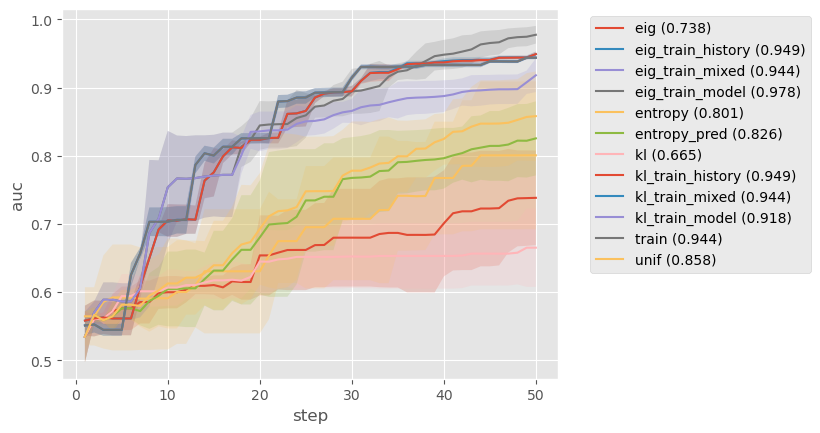

In [29]:
data = pd.read_csv(csv)
plt.style.use("ggplot")
n_seeds = len(data["seed"].unique())
for strategy, auc_group in data.groupby("strategy")["auc"]:
    aucs = np.array([eval(l) for l in auc_group.values])
    mean_auc = aucs.mean(axis=0)
    ci_rad = 1.96*aucs.std(axis=0)/np.sqrt(n_seeds)
    x = range(1, len(mean_auc)+1)
    plt.plot(x, mean_auc, label=f"{strategy} ({round(np.max(mean_auc), 2)})")
    plt.fill_between(x, mean_auc-ci_rad, mean_auc+ci_rad, alpha=0.2)
plt.ylabel("auc")
plt.xlabel("step")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig("testrun.pdf", bbox_inches="tight")